<a href="https://www.kaggle.com/code/catalystcooperative/04-renewable-generation-profiles?scriptVersionId=202379156" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Using the VCE Resource Adequacy Renewable Energy (RARE) Dataset

The RARE dataset, `vcerare` in PUDL, was produced by Vibrant Clean Energy and consists of hourly, county-level renewable generation profiles for solar PV, onshore, and offshore wind in the continental United States. It was produced using outputs from the [NOAA High Resolution Rapid Refresh (HRRR) weather model](https://rapidrefresh.noaa.gov/hrrr/). Visit our [VCE Data Source](https://catalystcoop-pudl.readthedocs.io/en/nightly/data_sources/vcerare.html) page to learn more. This data is released to the public by VCE under the [CC-BY-4.0 Attribution](https://creativecommons.org/licenses/by/4.0/) license.

## Accessing VCE RARE via CSV or Parquet

The VCE RARE data is distributed in two forms:

* **Raw CSV archives (Zenodo)**
* **Processed PUDL Parquet files (Kaggle, AWS S3, Zenodo)**

### Raw CSV archives (Zenodo)

The raw data is organized into multiple CSV files -- each one contains a single year for data for a single type of generation (solar PV, onshore wind, offshore wind), an index column for the hour of the year (1 - 8760) and one column for each of the ~3000 counties containing the modeled capacity factor. This format is optimized for use in Excel and limits the number of rows and columns so that Excel can handle handle it.

See the [README in the Zenodo archive](https://zenodo.org/records/13937523) for more detail on the raw data.

### Processed PUDL Parquet files (Kaggle, AWS S3, versioned PUDL releases on Zenodo)

The processed data are published as a single [Apache Parquet](https://parquet.apache.org/) file. Parquet is an open file format designed for doing analytical work with larger datasets. The processed data has been reshaped from the original wide format to use a [tidy data format](https://www.jstatsoft.org/article/view/v059i10/). The county is pivoted down into its own column rather than being a column header.

Additional columns are added to make data selection easier, and enable use in combination with other datasets. 

* Latitude
* Longitude
* County FIPS code
* Report year
* Timestamp (UTC)
* Separate state and county name fields (the raw data column headers are formatted as County_Name_State_Name)

Take a look at our [data dictionary](https://catalystcoop-pudl.readthedocs.io/en/nightly/data_dictionaries/pudl_db.html#out-vcerare-hourly-available-capacity-factor) for more information on the processed table schema.

### Which one should you use?

If you want or need to alter the layout of the data in order to feed it into your model, are interested in a particular subset of the data, want to connect it to geospatial data, or want to view / run analysis on all the data at once, the processed PUDL Parquet files are the way to go! For context, the row limit in Excel is a little more than 1 million rows. The processed PUDL table contains 136,437,000 rows. Below, we'll show you how to wrangle this dataset without blowing up your computer.

If you're working in Excel, or the wide-format 8760 data is the exact shape you need for modeling, then you may prefer to use the raw CSV files.

This notebook also includes examples of how to select and download a subset of the Parquet data as a CSV.

In [1]:
import pandas as pd
from pathlib import Path

# Read the data from Parquet and SQLite using Pandas

* First we'll define a couple of paths pointing to where the data lives on Kaggle.
* Then we'll read the entire VCE RARE dataset into a Pandas dataframe and inspect it.

In [2]:
# These paths are where we can find the PUDL data on the Kaggle machine
pudl_path = Path("/kaggle/input/pudl-project")
pq_path = pudl_path / "pudl_parquet"
assert pq_path.exists()

# Load the full RARE dataset from Parquet into a pandas dataframe
usa_rare = pd.read_parquet(
    pq_path / "out_vcerare__hourly_available_capacity_factor.parquet",
    engine="pyarrow",
    dtype_backend="pyarrow",
)

# Inspect the first few of the big dataframe
usa_rare.head(10)

,datetime_utc,hour_of_year,report_year,county_id_fips,county_or_lake_name,state,latitude,longitude,capacity_factor_solar_pv,capacity_factor_onshore_wind,capacity_factor_offshore_wind
0,2019-01-01 00:00:00,1,2019,45001,abbeville,SC,34.223488,-82.458885,0.0,0.576514,0.592741
1,2019-01-01 00:00:00,1,2019,22001,acadia,LA,30.294407,-92.411354,0.0,0.000564,0.0
2,2019-01-01 00:00:00,1,2019,51001,accomack,VA,37.877872,-75.591232,0.0,0.587439,0.970934
3,2019-01-01 00:00:00,1,2019,16001,ada,ID,43.450245,-116.24041,0.007291,0.300578,0.0
4,2019-01-01 00:00:00,1,2019,19001,adair,IA,41.328396,-94.471359,0.0,0.996613,0.0
5,2019-01-01 00:00:00,1,2019,21001,adair,KY,37.10574,-85.279732,0.0,0.919268,0.0
6,2019-01-01 00:00:00,1,2019,29001,adair,MO,40.193512,-92.59639,0.0,0.519462,0.0
7,2019-01-01 00:00:00,1,2019,40001,adair,OK,35.887959,-94.662949,0.0,0.026519,0.0
8,2019-01-01 00:00:00,1,2019,08001,adams,CO,39.872505,-104.330345,0.0,0.548774,0.0
9,2019-01-01 00:00:00,1,2019,16003,adams,ID,44.826714,-116.363823,0.000134,0.616433,0.0


In [3]:
# How big is this data and what are the types?
usa_rare.info(memory_usage="deep", show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136437000 entries, 0 to 136436999
Data columns (total 11 columns):
 #   Column                         Non-Null Count      Dtype                 
---  ------                         --------------      -----                 
 0   datetime_utc                   136437000 non-null  timestamp[ms][pyarrow]
 1   hour_of_year                   136437000 non-null  int32[pyarrow]        
 2   report_year                    136437000 non-null  int32[pyarrow]        
 3   county_id_fips                 135955200 non-null  string[pyarrow]       
 4   county_or_lake_name            136437000 non-null  string[pyarrow]       
 5   state                          136437000 non-null  string[pyarrow]       
 6   latitude                       136437000 non-null  float[pyarrow]        
 7   longitude                      136437000 non-null  float[pyarrow]        
 8   capacity_factor_solar_pv       136437000 non-null  float[pyarrow]        
 9   capacity_

## Load geospatial data to make maps

* The processed Parquet version of the VCE RARE data includes standardized FIPS codes, making it easy to join with geospatial data from the US Census and other sources at the county level.
* PUDL includes the Census Demographic Profile 1 (DP1) database, which reports demographic information at the census tract, county, and state level, and also provides geometries for each of those areas.
* We'll load the DP1 data and grab the geometries so we can make some maps showing us what the renewable generation profiles look like.

In [4]:
import geopandas as gpd
import sqlalchemy as sa
import matplotlib
import matplotlib.pyplot as plt

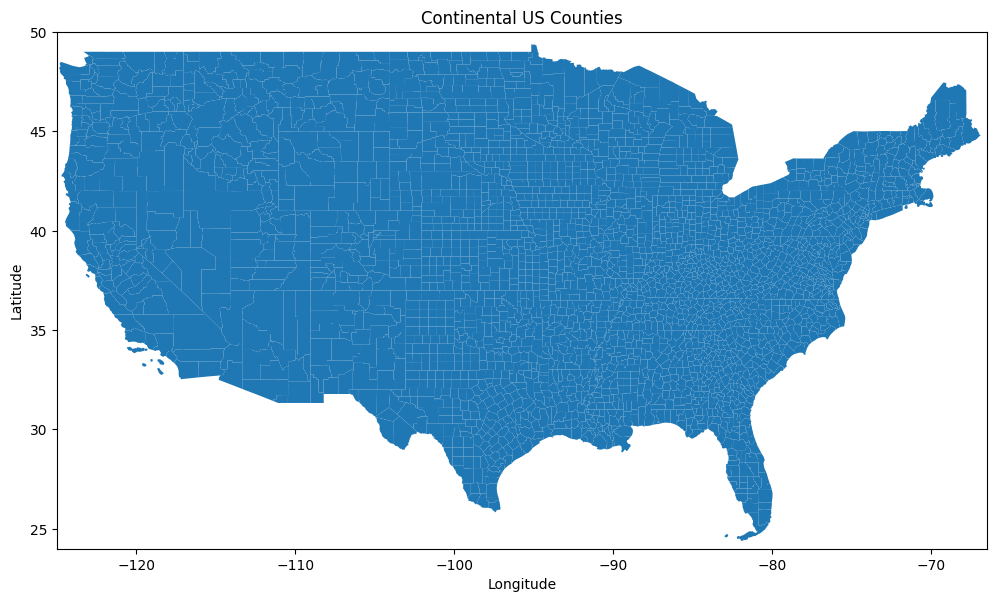

In [5]:
# Create the SQLAlchemy engine connecting to census spatial data
dp1_engine = sa.create_engine("sqlite:///" + str((pudl_path / "censusdp1tract.sqlite").absolute()))

# Read the county geometries from the database
county_gdf = (
    gpd.read_postgis(
        "county_2010census_dp1",
        con=dp1_engine,
        geom_col="shape"
    )
    .rename(columns={"geoid10": "county_id_fips", "shape": "geometry"})
    .set_geometry("geometry")
    .set_crs("EPSG:4326")
    .loc[:, ["county_id_fips", "geometry"]]
    .assign(county_id_fips=lambda x: x["county_id_fips"].astype("string"))
)

# Filter out Alaska, Hawaii, and other territories
conus_counties = county_gdf[
    ~county_gdf["county_id_fips"].str.startswith(("02", "15", "60", "66", "69", "72", "78"))
]

# Plot the continental US with a larger figure size
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
conus_counties.plot(ax=ax)

# Set axis limits to focus on the continental US
ax.set_xlim(-125, -66.5)
ax.set_ylim(24, 50)

# Add title and labels
ax.set_title('Continental US Counties')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

## Filter the data for a single state

* The make things run a bit faster in the examples below, we'll work with a single state at a time.
* We can select a single state's worth of data from the nationwide dataframe using the state abbreviation.

In [6]:
colorado_rare = usa_rare[usa_rare.state == "CO"].dropna(subset=["county_id_fips"])
colorado_rare.info(memory_usage="deep", show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2803200 entries, 8 to 136436996
Data columns (total 11 columns):
 #   Column                         Non-Null Count    Dtype                 
---  ------                         --------------    -----                 
 0   datetime_utc                   2803200 non-null  timestamp[ms][pyarrow]
 1   hour_of_year                   2803200 non-null  int32[pyarrow]        
 2   report_year                    2803200 non-null  int32[pyarrow]        
 3   county_id_fips                 2803200 non-null  string[pyarrow]       
 4   county_or_lake_name            2803200 non-null  string[pyarrow]       
 5   state                          2803200 non-null  string[pyarrow]       
 6   latitude                       2803200 non-null  float[pyarrow]        
 7   longitude                      2803200 non-null  float[pyarrow]        
 8   capacity_factor_solar_pv       2803200 non-null  float[pyarrow]        
 9   capacity_factor_onshore_wind   2803200

## Join county geometries to generation profiles

* Here we merge in the county geometries so that each record in the Colorado dataframe knows what geography it pertains to.

In [7]:
colorado_gdf = (
    pd.merge(county_gdf, colorado_rare, on="county_id_fips")
    .assign(county_id_fips=lambda x: x["county_id_fips"].astype("string"))
)
colorado_gdf.head(10)

,county_id_fips,geometry,datetime_utc,hour_of_year,report_year,county_or_lake_name,state,latitude,longitude,capacity_factor_solar_pv,capacity_factor_onshore_wind,capacity_factor_offshore_wind
0,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 00:00:00,1,2019,larimer,CO,40.652908,-105.34108,0.0,0.132354,0.0
1,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 01:00:00,2,2019,larimer,CO,40.652908,-105.34108,0.0,0.09316,0.0
2,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 02:00:00,3,2019,larimer,CO,40.652908,-105.34108,0.0,0.085482,0.0
3,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 03:00:00,4,2019,larimer,CO,40.652908,-105.34108,0.0,0.077217,0.0
4,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 04:00:00,5,2019,larimer,CO,40.652908,-105.34108,0.0,0.104628,0.0
5,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 05:00:00,6,2019,larimer,CO,40.652908,-105.34108,0.0,0.118982,0.0
6,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 06:00:00,7,2019,larimer,CO,40.652908,-105.34108,0.0,0.09944,0.0
7,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 07:00:00,8,2019,larimer,CO,40.652908,-105.34108,0.0,0.081115,0.0
8,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 08:00:00,9,2019,larimer,CO,40.652908,-105.34108,0.0,0.090724,0.0
9,08069,"MULTIPOLYGON (((-105.05672 40.34928, -105.0567...",2019-01-01 09:00:00,10,2019,larimer,CO,40.652908,-105.34108,0.0,0.100596,0.0


# Visualizing the Wind and Solar Generation Profiles

## Compare Wind and Solar for a single hour

Let's look at the wind and solar capacity factors in Colorado for a single hour, side by side.

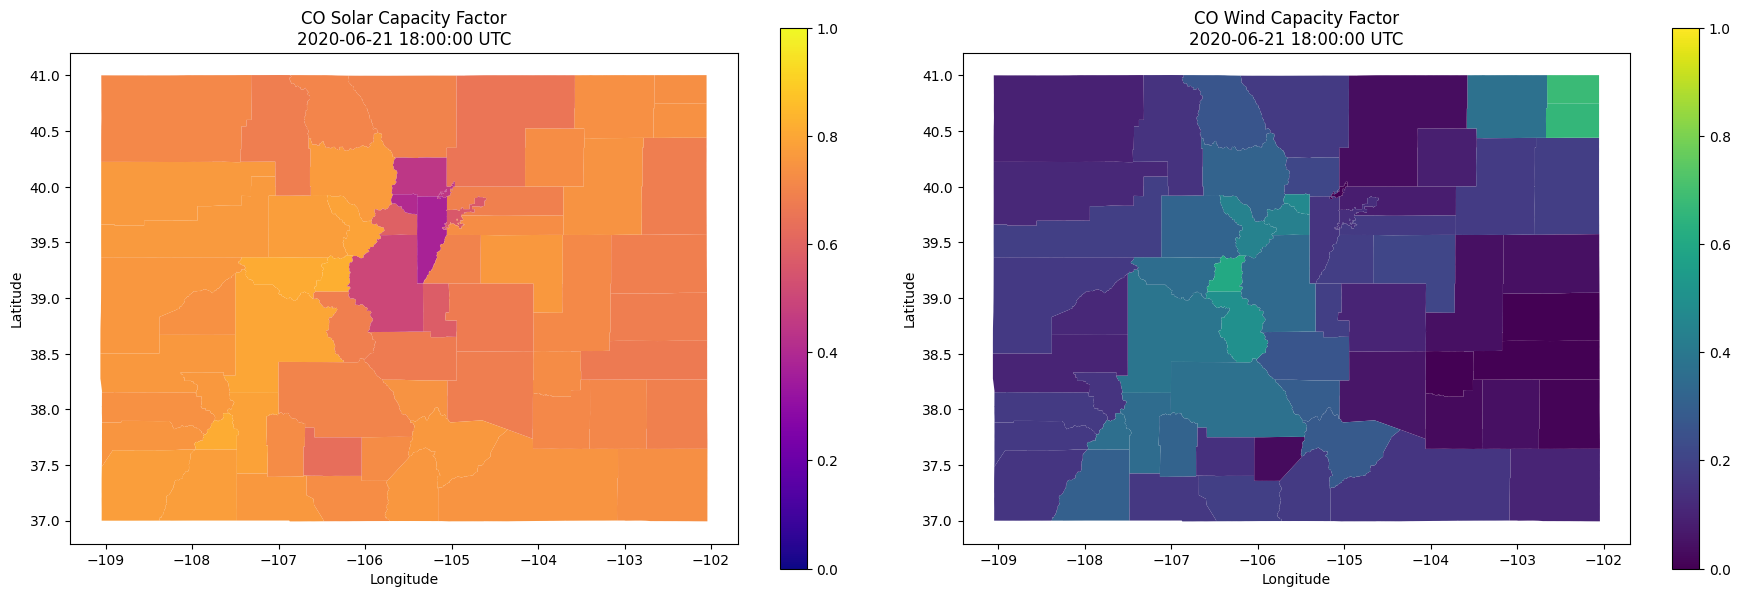

In [8]:
ts = pd.to_datetime("2020-06-21 18:00:00")
one_hour = colorado_gdf[colorado_gdf.datetime_utc == ts]
fig, (solar_ax, wind_ax) = plt.subplots(1, 2, figsize=(18, 6))

plt.tight_layout()

kwargs = {
    "legend": True,
    "vmin": 0,
    "vmax": 1,
}

one_hour.plot(
    column="capacity_factor_solar_pv",
    ax=solar_ax,
    cmap="plasma",
    **kwargs,
)

solar_ax.set_title(f"CO Solar Capacity Factor\n{ts} UTC")
solar_ax.set_xlabel("Longitude")
solar_ax.set_ylabel("Latitude")

one_hour.plot(
    column="capacity_factor_onshore_wind",
    ax=wind_ax,
    cmap="viridis",
    **kwargs,
)

wind_ax.set_title(f"CO Wind Capacity Factor\n{ts} UTC")
wind_ax.set_xlabel("Longitude")
wind_ax.set_ylabel("Latitude")

plt.show()

## Animated Capacity Factor Maps

* Seeing how renewable energy outputs vary with time is much more interesting than a static snapshot.
* Matplotlib has some tools that will let us build animated maps from the hourly county timeseries contained in the RARE data.
* The `animate_capacity_factor()` function below will let us flexibily create a variety of different animated maps.

In [9]:
import matplotlib.animation as animation
from tqdm import tqdm

def animate_capacity_factor(
    data: pd.DataFrame,
    counties: gpd.GeoDataFrame,
    column: str,
    prefix: str,
    start: str | pd.Timestamp,
    end: str | pd.Timestamp,
    colormap: str = 'plasma',
    frame_duration_ms: int = 100
) -> None:
    """Create an animated plot of a capacity factor column for a specific date range.

    Args:
        data: DataFrame containing the capacity factor data with columns
            'county_id_fips', 'datetime_utc', and the specified capacity factor column.
        counties: GeoDataFrame containing the geometries of the counties with a
            'county_id_fips' column.
        column: The name of the capacity factor column to be animated.
        prefix: Added to the beginning of the filename when saving the video.
        start: The start datetime for the animation.
        end: The end datetime for the animation.
        colormap: The colormap to be used for the plot. Default is 'plasma'.
        frame_duration_ms: Duration of each frame in milliseconds. Default is 100 ms.

    Returns:
        None: The function saves the animation as an MP4 file and displays the last frame.

    """
    # Convert start and end datetimes to pandas datetime
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    # Filter for the specific date range
    geodata = gpd.GeoDataFrame(
        data.loc[data.datetime_utc.between(start, end), ["county_id_fips", "datetime_utc", column]]
        .merge(counties, on="county_id_fips")
        .assign(county_id_fips=lambda x: x["county_id_fips"].astype("string"))
    )

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Set the initial title here so that it's not clipped by tight_layout() later.
    ax.set_title(f'{column.replace("_", " ").title()} {start} UTC', fontdict={'fontsize': 15})
    plt.tight_layout()

    # Create a tqdm progress bar
    num_frames = len(geodata.datetime_utc.unique())
    progress_bar = tqdm(total=num_frames, desc="Rendering Frames")

    # Function to update the plot for each frame
    def update(frame):
        ax.clear()
        ax.axis('off')  # Ensure the axis is turned off after clearing
        # Filter data for the current hour
        current_time = geodata.datetime_utc.unique()[frame]
        current_data = geodata[geodata.datetime_utc == current_time]

        # Plot the current data
        current_data.plot(
            column=column,
            cmap=colormap,
            linewidth=0.1,
            ax=ax,
            edgecolor='0.1',
            vmin=0,
            vmax=1
        )
        ax.set_title(f'{column.replace("_", " ").title()} {current_time} UTC', fontdict={'fontsize': 15})
        progress_bar.update(1)

    anim = animation.FuncAnimation(fig, update, frames=num_frames, repeat=True)
    writer = animation.FFMpegWriter(fps=1000 / frame_duration_ms)
    anim.save(f"{prefix}{column}.mp4", writer=writer)
    progress_bar.close()
    plt.close(fig)

## A Windy Day in Texas

* Instead of Colorado, let's take a look at Texas, which now has more wind and solar capacity installed than any other state.

In [10]:
texas_rare = usa_rare.loc[usa_rare.state == "TX"]

In [11]:
start = "2020-06-21 00:00:00"
end = "2020-06-21 23:00:00"
frame_duration_ms = 100

animate_capacity_factor(
    data=texas_rare,
    counties=county_gdf,
    column="capacity_factor_onshore_wind",
    prefix="texas_",
    start=start,
    end=end,
    colormap="viridis",
    frame_duration_ms=frame_duration_ms,
)

Rendering Frames: 25it [00:23,  1.09it/s]


### View the Video

* The function above saved the video to disk, but we can read that file and play it in the notebook in the next cell.
* You can also download the file to your own computer and view it in a web browser or video player.
* Expand the "Output" section in the sidebar on the right side of this notebook (on Kaggle) and hover over the filename.
* You'll see three dots to the right of the filename with options for actions, including downloading the file and saving it locally

In [12]:
from IPython.display import Video
Video('texas_capacity_factor_onshore_wind.mp4')

## A Sunny Day in Texas

Now let's look at solar capacity factors over the same day in Texas.

In [13]:
animate_capacity_factor(
    data=texas_rare,
    counties=county_gdf,
    column="capacity_factor_solar_pv",
    prefix="texas_",
    start=start,
    end=end,
    colormap="plasma",
    frame_duration_ms=frame_duration_ms,
)

Rendering Frames: 25it [00:22,  1.09it/s]


In [14]:
Video('texas_capacity_factor_solar_pv.mp4')

# Downloading a CSV

* We can use pandas to save the Texas data to a CSV on Kaggle.
* The "Output" panel in the right sidebar of the notebook will show the saved file.
* You can click on it to download, and hover to see how big it is.
* Make sure that the CSV has less than a million rows or Excel won't be able to open it.
* CSVs that are more than a few hundred MB may also cause problems.

## Too Big to Excel?
* Using the `len()` function, we can see that there are more than 11 million rows of Texas data, so if we save it as a CSV Excel won't be able to open it.
* Depending on what you need the data for you might take one of several different approaches:
  * Divide it into smaller timespans (say, quarterly) so that each one can be opened in Excel.
  * Select only a subset of the counties that you need.
  * Select only counties within a given distance of a city of interest based on latitude & longitude.
  * Reshape the data back into a wide format so it has more columns and fewer rows.

In [15]:
# How big is the Texas generation profile data?
# Too many for Excel!
len(texas_rare)

11125200

## Make Texas Wide Again

* To split this dataframe into chunks that work with Excel we would have to create at least a dozen CSVs.
* Instead we will reshape it into a wide format resembling the original raw CSVs and save it.
* 5 years of 8760 data will result in 43800 rows.
* Each column will correspond to a place (count).
* We'll have to discard all of the other information about the place (lat/lon, FIPS code).
* Each of the data columns (solar PV, onshore wind, & offshore wind) will end up in a separate file.
* There will be ~250 columns -- one for each county in Texas.

In [16]:
# We'll keep the time columns as the index in the reshaped dataframe.
time_cols = [
    "report_year",
    "hour_of_year",
    "datetime_utc",
]

# Each of the data columns will be used to create a separate CSV
data_cols = [
    "capacity_factor_solar_pv",
    "capacity_factor_onshore_wind",
    "capacity_factor_offshore_wind",
]

unstacked = {}
# For each of the data columns:
for data_col in data_cols:
    unstacked[data_col] = (
        # Create a composite place__state column which will be used as output column headers
        texas_rare.assign(place_name=lambda df: df["county_or_lake_name"] + "__" + df["state"].str.lower())
        # Make the time and place columns the dataframe index in preparation for unstacking
        .set_index(time_cols + ["place_name"])
        # Other than the index columns, only the data column will be retained:
        .loc[:, [data_col]]
        # Convert each value within the place_name column into its own column header
        .unstack("place_name")
    )
    # Simplify the dataframe column multi-index to produce a simple CSV output
    unstacked[data_col].columns = unstacked[data_col].columns.droplevel()
    unstacked[data_col].columns.name = None
    unstacked[data_col] = unstacked[data_col].reset_index()
    # Save the CSV, without the integer index column
    unstacked[data_col].to_csv(f"{data_col}.csv", index=False)

In [17]:
unstacked["capacity_factor_solar_pv"].shape

(43800, 257)

In [18]:
unstacked["capacity_factor_solar_pv"]

,report_year,hour_of_year,datetime_utc,anderson__tx,andrews__tx,angelina__tx,aransas__tx,archer__tx,armstrong__tx,atascosa__tx,...,willacy__tx,williamson__tx,wilson__tx,winkler__tx,wise__tx,wood__tx,yoakum__tx,young__tx,zapata__tx,zavala__tx
0,2019,1,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019,2,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,3,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,4,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,5,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2023,8756,2023-12-31 19:00:00,0.478205,0.815655,0.486621,0.608957,0.571901,0.74037,0.751983,...,0.701344,0.772169,0.761171,0.818361,0.492159,0.457078,0.822546,0.655998,0.769075,0.768578
43796,2023,8757,2023-12-31 20:00:00,0.475616,0.760839,0.411626,0.541783,0.428161,0.736186,0.687952,...,0.640594,0.687755,0.687351,0.762727,0.395522,0.373829,0.767546,0.478981,0.705326,0.70769
43797,2023,8758,2023-12-31 21:00:00,0.437149,0.626489,0.301823,0.478662,0.287033,0.588715,0.54395,...,0.505663,0.53085,0.535899,0.625765,0.319774,0.271825,0.630191,0.311161,0.565043,0.567476
43798,2023,8759,2023-12-31 22:00:00,0.222166,0.419079,0.139857,0.276433,0.107385,0.364805,0.32679,...,0.302033,0.304022,0.315331,0.420701,0.210894,0.143416,0.418215,0.099864,0.358323,0.357441


## Inspect the outputs
* Download the CSV using the menu in the "Output" sidebar on the right.
* How big are the CSVs we just saved? Can you open them in Excel?
* Let's read one of them back into pandas and take a look at it.

In [19]:
texas_solar_csv = pd.read_csv(
    "capacity_factor_solar_pv.csv",
    parse_dates=["datetime_utc"],
    engine="pyarrow",
    dtype_backend="pyarrow",
)
texas_solar_csv

,report_year,hour_of_year,datetime_utc,anderson__tx,andrews__tx,angelina__tx,aransas__tx,archer__tx,armstrong__tx,atascosa__tx,...,willacy__tx,williamson__tx,wilson__tx,winkler__tx,wise__tx,wood__tx,yoakum__tx,young__tx,zapata__tx,zavala__tx
0,2019,1,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019,2,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,3,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,4,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,5,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2023,8756,2023-12-31 19:00:00,0.478205,0.815655,0.486621,0.608957,0.571901,0.74037,0.751983,...,0.701344,0.772169,0.761171,0.818361,0.492159,0.457078,0.822546,0.655998,0.769075,0.768578
43796,2023,8757,2023-12-31 20:00:00,0.475616,0.760839,0.411626,0.541783,0.428161,0.736186,0.687952,...,0.640594,0.687755,0.687351,0.762727,0.395522,0.373829,0.767546,0.478981,0.705326,0.70769
43797,2023,8758,2023-12-31 21:00:00,0.437149,0.626489,0.301823,0.478662,0.287033,0.588715,0.54395,...,0.505663,0.53085,0.535899,0.625765,0.319774,0.271825,0.630191,0.311161,0.565043,0.567476
43798,2023,8759,2023-12-31 22:00:00,0.222166,0.419079,0.139857,0.276433,0.107385,0.364805,0.32679,...,0.302033,0.304022,0.315331,0.420701,0.210894,0.143416,0.418215,0.099864,0.358323,0.357441


In [20]:
texas_solar_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Columns: 257 entries, report_year to zavala__tx
dtypes: double[pyarrow](254), int64[pyarrow](2), timestamp[s][pyarrow](1)
memory usage: 85.9 MB


# Statistical Explorations

## A Capacity Factor Histogram

In [21]:
# Select a county by 5-digit county FIPS ID"
hist_county_id_fips = "08075" # Logan County, CO. If you want, add your custom 5 digit code here instead
hist_gen_type = "onshore_wind" # Choose from: solar_pv, onshore_wind, offshore_wind

In [22]:
plot_df = usa_rare.loc[usa_rare["county_id_fips"] == hist_county_id_fips]

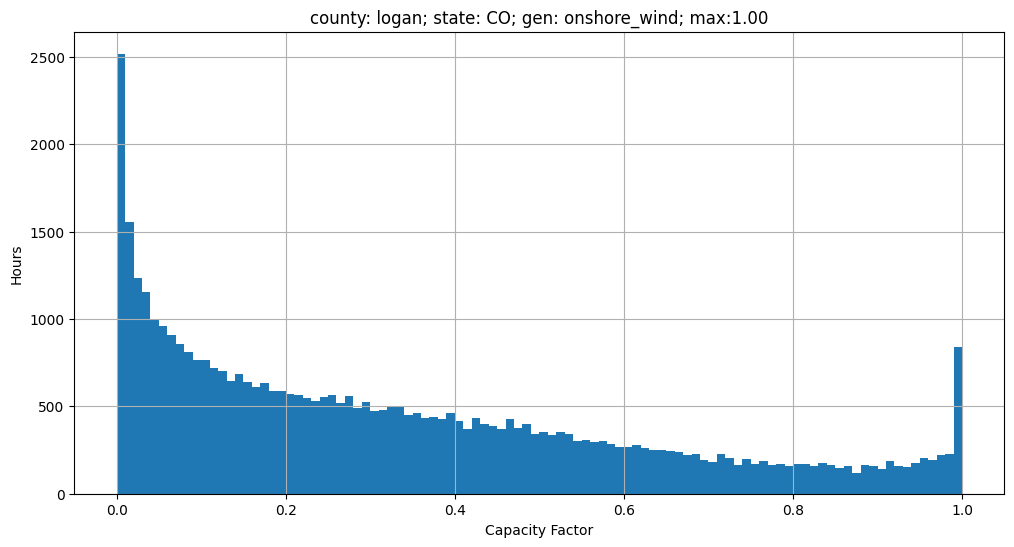

In [23]:
# Make the chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.hist(plot_df[f"capacity_factor_{hist_gen_type}"], bins=100, range=(0, 1))
county_name = plot_df[plot_df["county_id_fips"]==hist_county_id_fips].county_or_lake_name.unique()[0]
state_name = plot_df[plot_df["county_id_fips"]==hist_county_id_fips].state.unique()[0]
plt.title(
    f"county: {county_name}; state: {state_name}; gen: {hist_gen_type}; max:{plot_df[f'capacity_factor_{hist_gen_type}'].max():.2f}"
)
plt.xlabel("Capacity Factor")
plt.ylabel("Hours")
plt.grid()
plt.show()

## An Interactive Plot with Altair

In [24]:
state = "TX" # Input your desired state
annual_year = 2023 # Input your desired year

In [25]:
cap_fac_cols = ['solar_pv', 'onshore_wind', 'offshore_wind']

# Remove capacity_factor prefix from columns
rare_df_copy = usa_rare.copy()
rare_df_copy.columns = [
    col.replace('capacity_factor_', '') if col.startswith('capacity_factor_') else col
    for col in rare_df_copy.columns
]

# Filter based on year and state
rare_year_state_subset_raw = rare_df_copy[
    (rare_df_copy["report_year"] == annual_year) & (rare_df_copy["state"] == state)
]

# Calculate both mean and variance, then stack and reshape
agg_funcs = {col: ['mean', 'var'] for col in cap_fac_cols}
stats_df = rare_year_state_subset_raw.groupby(
    ["report_year", "state", "county_or_lake_name", "county_id_fips"]
).agg(agg_funcs)

# Stack and reshape to combine mean and variance
rare_year_state_subset_final = stats_df.stack(level=0).reset_index()
rare_year_state_subset_final.columns = ["report_year", "state", "county_or_lake_name", "county_id_fips", "gen_type", "average_capacity_factor", "average_variance"]

/tmp/ipykernel_17/1873238917.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  rare_year_state_subset_final = stats_df.stack(level=0).reset_index()


In [26]:
import altair as alt
# Define the data source for the chart
source = rare_year_state_subset_final

# Set the color scheme for the chart
color = alt.Color('gen_type:N').scale(
    domain=['solar_pv', 'onshore_wind', 'offshore_wind'],
    range=['#e7ba52', '#69b373', '#aec7e8']
)

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_point(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_point().encode(
    alt.X('average_variance:Q', title='Annual Variance'),
    alt.Y('average_capacity_factor:Q', title='Annual Average Capacity Factor')
        .scale(domain=[0, 1]),
    color=alt.condition(brush, color, alt.value('lightgray')),
    tooltip=[
        alt.Tooltip('county_or_lake_name:N', title='County Name'),
        alt.Tooltip('county_id_fips:N', title='FIPS ID'),
        alt.Tooltip('average_capacity_factor:Q', title='Average Annual Capacity Factor', format='.2f'),  # Rounded to 2 decimals
        alt.Tooltip('average_variance:Q', title='Average Annual Variance', format='.2f'),  # Rounded to 2 decimals
    ]
).properties(
    width=1000,
    height=550
).add_params(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of average capacity factor per generation type
bars = alt.Chart().mark_bar().encode(
    x=alt.X('average(average_capacity_factor):Q', title='Average Capacity Factor (Excluding Outliers)'),
    y=alt.Y('gen_type:N', title='Generation Type'),
    color=alt.condition(click, color, alt.value('lightgray')),
    tooltip=[
        alt.Tooltip('gen_type:N', title='Generation Type'),
        alt.Tooltip('average(average_capacity_factor):Q', title='Average Capacity Factor', format='.2f')
    ]
).transform_filter(
    (alt.datum.average_capacity_factor > 0) & brush
).properties(
    width=1000,
).add_params(
    click
)

alt.vconcat(
    points,
    bars,
    data=source,
    title=f"Average Capacity Factor vs. Variance for Counties in {state} in {annual_year}"
).configure_title(
    fontSize=24,
    anchor="middle",
    dy=-10,
).configure_axis(
    titleFontSize=16,  # Adjust the axis title font size
    titleFontWeight='bold',  # Set axis title to bold
    titleColor='black',  # Set axis title color
    labelFontSize=12,  # Adjust the axis label font size
    labelColor='gray',
    titlePadding=10,
)

alt.VConcatChart(...)